# DataDrive2030 Early Learning Predictors 

## Importing librairies

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# models
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
# tuning
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import mean_squared_error
# model Interpretability library
import eli5
# utils
import random
from tqdm import tqdm
from datetime import datetime as dt
import joblib

In [2]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

## Data loading

In [3]:
DATA_PATH = 'data/'
# Load files
train = pd.read_csv(DATA_PATH + 'Train.csv', low_memory=False)
test = pd.read_csv(DATA_PATH + 'Test.csv', low_memory=False)
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv', low_memory=False)
variable_description = pd.read_csv(DATA_PATH + 'VariableDescription.csv', low_memory=False)

In [4]:
# Preview train
train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,...,obs_cooking_5,obs_cooking_6,obs_heating_1,obs_heating_2,obs_heating_3,obs_heating_4,obs_heating_5,obs_heating_6,obs_heating_7,target
0,ID_SYSJ2FM0D,2022.0,2022-02-03,59.000000,NaN,NaN,NaN,NaN,NaN,Sometimes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
1,ID_J5BTFOZR3,2019.0,NaN,60.163933,NaN,NaN,NaN,1st year in the programme,103.000000,Sometimes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.869999
2,ID_R00SN7AUD,2022.0,2022-03-11,69.000000,NaN,NaN,NaN,NaN,108.400002,Often,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.520000
3,ID_BSSK60PAZ,2021.0,2021-10-13,53.000000,2020-01-15,20.0,No,1st year in the programme,98.099998,Almost always,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.599998
4,ID_IZTY6TC4D,2021.0,2021-10-13,57.000000,2021-10-13,0.0,NaN,2nd year in programme,114.000000,Almost always,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,76.599998


## EDA

In [5]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train.shape)
print('Dimension du test set :', test.shape)

Dimension du train set : (8585, 679)
Dimension du test set : (3680, 678)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8585 entries, 0 to 8584
Columns: 679 entries, child_id to target
dtypes: float64(160), object(519)
memory usage: 44.5+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Columns: 678 entries, child_id to obs_heating_7
dtypes: float64(161), object(517)
memory usage: 19.0+ MB


In [8]:
ID = 'child_id'
TARGET = 'target'

In [9]:
train.select_dtypes(include='object').describe()

,child_id,child_date,child_enrolment_date,child_grant,child_years_in_programme,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_gender,...,sanitation_learners,positionother,positionotherreason,sef_ind,elp_ind,gps_ind,pre_covid,quintile_used,language_assessment_w2,ses_cat
count,8585,6764,2621,5452,7879,8585,8585,8585,8585,8585,...,387,13,13,8585,7042,7720,8585,7850,505,5665
unique,8585,254,535,4,4,4,4,4,4,2,...,3,2,2,2,2,2,2,2,9,5
top,ID_SYSJ2FM0D,2021-10-20,2021-02-15,Yes,1st year in the programme,Often,Often,Sometimes,Often,Female,...,1,Secretary/Administrator,All above in meeting,Yes,Yes,Yes,Post COVID,No,Setswana,R0-110
freq,1,138,212,4515,4369,3192,3102,2887,2909,4442,...,378,8,8,7246,4656,6250,7411,4930,101,1999


In [10]:
train.select_dtypes(include='number').describe()

,data_year,child_age,child_months_enrolment,child_height,child_observe_total,child_zha,child_attendance,ward_best,id_enumerator,id_facility,...,obs_cooking_5,obs_cooking_6,obs_heating_1,obs_heating_2,obs_heating_3,obs_heating_4,obs_heating_5,obs_heating_6,obs_heating_7,target
count,8585.000000,8585.000000,2621.000000,6969.000000,7883.000000,6923.000000,1320.00000,5572.000000,7162.000000,8573.000000,...,2256.000000,2256.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000,8585.000000
mean,2020.983692,58.116873,20.476917,106.949312,7.381454,-0.367788,4.70303,25.875269,7124.970399,1213.428438,...,0.074468,0.019947,0.194162,0.643078,0.002211,0.072092,0.050420,0.026095,0.011942,48.693783
std,0.920267,5.318927,14.096259,6.430768,3.256987,1.098113,0.76978,28.043010,8706.202270,684.145046,...,0.262589,0.139848,0.395642,0.479197,0.046984,0.258697,0.218859,0.159452,0.108647,15.160414
min,2019.000000,49.475410,0.000000,64.199997,0.000000,-5.868164,1.00000,1.000000,9.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.370000
25%,2021.000000,54.000000,8.000000,103.000000,5.000000,-1.064535,5.00000,7.000000,502.000000,638.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.599998
50%,2021.000000,57.000000,20.000000,106.599998,8.000000,-0.385991,5.00000,16.000000,2680.000000,1198.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.310001
75%,2022.000000,62.032787,33.000000,110.500000,10.000000,0.341011,5.00000,31.000000,20022.000000,1809.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.310001
max,2022.000000,69.683777,57.000000,159.000000,12.000000,5.540900,7.00000,130.000000,20090.000000,2361.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,96.809998


In [11]:
for colonne in list(train.select_dtypes(include='object').columns):
    print(colonne)
    print(train[colonne].value_counts(), '\n')

child_id
ID_SYSJ2FM0D    1
ID_26806EC22    1
ID_OGIHA5OC3    1
ID_GQ8AHBB6Z    1
ID_XB466G9EC    1
               ..
ID_77T015BWL    1
ID_AC0J86KJ2    1
ID_WRMS3OWQK    1
ID_MQFE8NW8S    1
ID_Y61LX4FV3    1
Name: child_id, Length: 8585, dtype: int64 

child_date
2021-10-20    138
2021-10-26    138
2021-11-10    138
2021-10-19    136
2021-10-28    136
             ... 
2020-12-04      1
2022-10-05      1
2021-03-22      1
2021-11-30      1
2021-08-06      1
Name: child_date, Length: 254, dtype: int64 

child_enrolment_date
2021-02-15    212
2021-01-15     97
2020-01-15     91
2019-01-15     66
2021-03-01     65
             ... 
2017-02-27      1
2019-04-23      1
2018-08-02      1
2020-08-24      1
2019-06-04      1
Name: child_enrolment_date, Length: 535, dtype: int64 

child_grant
Yes           4515
No             764
Don't know     168
Refuse           5
Name: child_grant, dtype: int64 

child_years_in_programme
1st year in the programme    4369
2nd year in programme        1917
3rd

In [12]:
missing_values = train.isnull().sum() / train.shape[0] * 100
missing_values

child_id                 0.000000
data_year                0.000000
child_date              21.211415
child_age                0.000000
child_enrolment_date    69.470006
                          ...    
obs_heating_4           73.663366
obs_heating_5           73.663366
obs_heating_6           73.663366
obs_heating_7           73.663366
target                   0.000000
Length: 679, dtype: float64

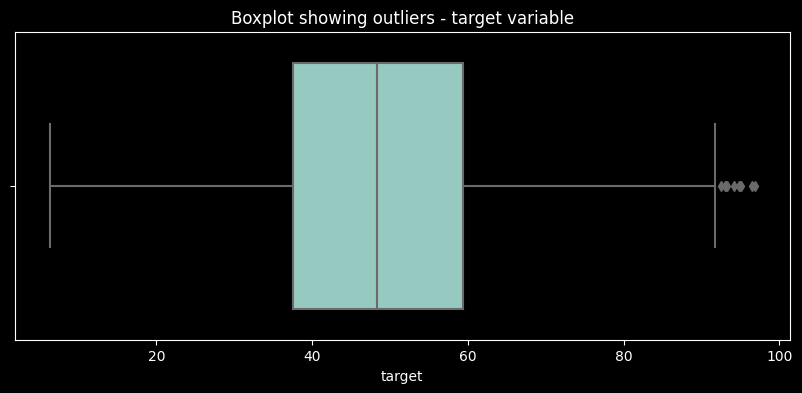

In [13]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 4))
sns.boxplot(x=train[TARGET])
plt.title('Boxplot showing outliers - target variable')
plt.show()

## Preprocessing

## Modeling

In [15]:
def rmse(y_test, y_pred) -> float:
    '''
    '''
    return mean_squared_error(y_test, y_pred, squared=False)

In [16]:
# For a simple model we will use only numerical columns
y = train[TARGET]

num_cols = list(set(test.select_dtypes('number')).intersection(train.select_dtypes('number')))
X = train[num_cols]
X = X.fillna(0)

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

### LinearRegression

In [17]:
# Train a model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Check score
rmse(y_test, y_pred_lr)

11.861381387687013

### LogisticRegression

In [ ]:
# Train a model
model_lgr = LogisticRegression(random_state=SEED)
model_lgr.fit(X_train, y_train)

# Make predictions
y_pred_lgr = model_lgr.predict(X_test)

# Check score
rmse(y_test, y_pred_lgr)

### CatBoostRegressor

In [19]:
# Train a model
model_cbr = CatBoostRegressor(random_state=SEED)
model_cbr.fit(X_train, y_train, verbose=100)

# Make predictions
y_pred_cbr = model_cbr.predict(X_test)

# Check score
rmse(y_test, y_pred_cbr)

Learning rate set to 0.055514
0:	learn: 14.9009991	total: 202ms	remaining: 3m 21s
100:	learn: 10.7041024	total: 1.9s	remaining: 16.9s
200:	learn: 9.8999944	total: 3.52s	remaining: 14s
300:	learn: 9.3979169	total: 5.33s	remaining: 12.4s
400:	learn: 8.9686587	total: 6.93s	remaining: 10.3s
500:	learn: 8.6048002	total: 8.7s	remaining: 8.67s
600:	learn: 8.3034207	total: 10.5s	remaining: 6.99s
700:	learn: 8.0526208	total: 12.8s	remaining: 5.47s
800:	learn: 7.8088684	total: 15s	remaining: 3.74s
900:	learn: 7.5957669	total: 17.3s	remaining: 1.9s
999:	learn: 7.3723474	total: 19.7s	remaining: 0us


10.285321348021569

### LGBMRegressor

In [20]:
# Train a model
model_lgbmr = LGBMRegressor()
model_lgbmr.fit(X_train, y_train)

# Make predictions
y_pred_lgbmr = model_lgbmr.predict(X_test)

# Check score
rmse(y_test, y_pred_lgbmr)

10.464648185894248

### SGDRegressor

In [21]:
# Train a model
model_sgdr = SGDRegressor(random_state=SEED)
model_sgdr.fit(X_train, y_train)

# Make predictions
y_pred_sgdr = model_sgdr.predict(X_test)

# Check score
rmse(y_test, y_pred_sgdr)

5.761248286380714e+23

### XGBRegressor

In [22]:
# Train a model
model_xgbr = XGBRegressor()
model_xgbr.fit(X_train, y_train)

# Make predictions
y_pred_xgbr = model_xgbr.predict(X_test)

# Check score
rmse(y_test, y_pred_xgbr)

10.728848224611733

## Model explanation

In [23]:
model = model_lgbmr

In [24]:
# Preview overall top 10 features
eli5.show_weights(model, feature_names=num_cols)

Weight,Feature
0.2364,child_observe_total
0.2216,child_age
0.0842,id_enumerator
0.0602,teacher_emotional_total
0.0355,id_ward
0.0330,longitude
0.0292,child_height
0.0219,child_zha
0.0216,id_facility
0.0208,pri_fees_amount


In [25]:
# Select a single/specific prediction
sample = X_train.iloc[[1]]
sample

,count_staff_contract_permanent,pqa_score_curriculum,pri_difficult_hear,count_staff_qual_skills,child_observe_total,count_staff_paid_maintenance,count_staff_paid_assistants,pri_difficult_see,count_staff_qual_nqf6_9,id_enumerator,...,pri_expense_admin,count_register_year_2014,count_practitioners_age_2,pri_time_close_minutes,count_register_year_2013,count_staff_paid_managers,obs_heating_7,data_year,pqa_score_environment,obs_heating_5
4123,0.0,0.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,20042.0,...,0.0,0.0,0.0,30.0,0.0,0.0,0.0,2021.0,0.0,0.0


In [26]:
# Preview top 5 predictors for the single/specific prediction
eli5.show_prediction(model_lgbmr, X_test.iloc[1], feature_names=num_cols, show_feature_values=True, top = 5)

In [27]:
# We can get the top 15 features as a pandas dataframe
eli5.explain_prediction_df(estimator=model, doc=X_test.iloc[1], top = 15)

,target,feature,weight,value
0,y,<BIAS>,48.793975,1.000000e+00
1,y,teacher_emotional_total,3.208139,1.200000e+01
2,y,child_observe_total,3.172666,9.000000e+00
3,y,pri_expense_other,0.343266,1.800000e+03
4,y,pri_time_close_hours,0.308925,1.300000e+01
5,y,id_ward,-0.359793,5.430502e+07
6,y,teacher_selfcare_total,-0.752311,3.000000e+00
7,y,pri_time_open_hours,-0.764077,8.000000e+00
8,y,ses_proxy,-0.805175,1.000000e+00
9,y,longitude,-0.822105,2.979180e+01


## Prediction

In [ ]:
model = model_lgbmr

: 

In [28]:
# Make predictions on the test set
preds = model.predict(test[num_cols].fillna(0))
preds

array([58.1011249 , 49.36765661, 49.74115308, ..., 40.61692162,
       38.70309141, 47.68277849])

In [29]:
# Get the top five features for each predictions
top_predictors = []
for i in tqdm(range(test.shape[0])):
    predictors = eli5.explain_prediction_df(
        estimator=model, doc=test[num_cols].fillna(0).iloc[i], top=15)
    top_predictors.append(predictors.feature.tolist())

100%|██████████| 3680/3680 [22:39<00:00,  2.71it/s]


## Submission

In [30]:
# Prepare your sub file to look like the provided sample submission
sample_submission.head()

,child_id,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,ID_0I0999N6S,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
1,ID_GQ6ONJ4FP,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
2,ID_YZ76CVRW3,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
3,ID_BNINCRXH8,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
4,ID_1U7GDTLRI,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature


In [31]:
# Submission file preparation
predictors = pd.DataFrame(top_predictors, columns = ['feature_' + str(i) for i in range(1,16)])
predictors[TARGET] = preds
predictors[ID] = test[ID]
predictors = predictors[sample_submission.columns.tolist()]
predictors.head()

,child_id,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,ID_0I0999N6S,58.101125,<BIAS>,child_observe_total,teacher_emotional_total,pri_fees_amount,pri_fees_amount_pv,id_enumerator,id_team,ses_proxy,latitude,count_register_year_2016,id_facility,pri_funding_subsidy,count_register_year_2020,child_age,id_ward
1,ID_GQ6ONJ4FP,49.367657,<BIAS>,child_observe_total,teacher_emotional_total,pri_fees_amount,pri_fees_amount_pv,pri_time_close_hours,id_facility,count_register_year_grader,child_height,latitude,id_team,id_prov_n,id_mn_n,id_enumerator,child_age
2,ID_YZ76CVRW3,49.741153,<BIAS>,id_enumerator,child_observe_total,pri_fees_amount,id_team,ses_proxy,id_ward,longitude,id_ward_n,count_register_race,pri_fees_amount_4_6,child_zha,latitude,child_age,teacher_emotional_total
3,ID_BNINCRXH8,68.464306,<BIAS>,child_observe_total,id_enumerator,longitude,child_age,child_zha,pri_capacity,id_prov_n,count_children_precovid,id_team,id_ward,count_staff_all,id_mn_n,ses_proxy,teacher_social_total
4,ID_1U7GDTLRI,42.201601,<BIAS>,child_observe_total,id_ward,count_register_gender_female,id_facility,ses_proxy,child_height,count_register_year_2016,pri_fees_amount,latitude,teacher_social_total,child_zha,id_enumerator,teacher_emotional_total,child_age


In [32]:
# Create csv to upload to Zindi for scoring
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
predictors.to_csv(f'submissions/soumission-{today}.csv', index=False)

## Saving model